# <font color='red'>Face_Mask_Detection_TL_MobileNetV2(Frame_Prediction)(Kaggle_Data)</font>
### The Data used here can be found through  <a href="https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset" target="_blank">`This Link`</a> on Kaggle Website. 

## All work here is done on `CoLab` 

## Import Libraries 

In [8]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
from sklearn.utils import shuffle
from scipy.spatial import distance
from IPython.display import Image
from PIL import Image as PImage
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

import os
import shutil, sys
from os import listdir
import pandas as pd
import random

## Create CAFFEE Folder for using to make Frame on Faces

In [15]:
os.mkdir('/content/CAFFEE')

In [16]:
# Upload (deploy.prototxt) and (res10_300x300_ssd_iter_140000.caffemodel) files from CAFFEE folder in my local drive
from google.colab import files
uploaded = files.upload()

Saving deploy.prototxt to deploy.prototxt
Saving res10_300x300_ssd_iter_140000.caffemodel to res10_300x300_ssd_iter_140000.caffemodel


In [17]:
shutil.move('/content/deploy.prototxt','/content/CAFFEE')
shutil.move('/content/res10_300x300_ssd_iter_140000.caffemodel','/content/CAFFEE')

'/content/CAFFEE/res10_300x300_ssd_iter_140000.caffemodel'

In [18]:
!ls CAFFEE

deploy.prototxt  res10_300x300_ssd_iter_140000.caffemodel


In [19]:
# using openCV DNN to build bounding box on each face

modelFile = "/content/CAFFEE/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "/content/CAFFEE/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

## Upload and Load my Model from Local drive

In [20]:
# Upload model.06-0.01.h5 from my local drive
from google.colab import files
uploaded = files.upload()

Saving model.06-0.01.h5 to model.06-0.01.h5


In [21]:
# Load model
model = load_model('model.06-0.01.h5')

## Define The Functions Required For Prediction

In [22]:
def predict_class(img_name, model):
    """
    Function to predict new image
    """
    result = model.predict(img_name)
    list_predict=result[0]
    list_predict = list_predict.tolist()
    return list_predict

In [23]:
def show_image(image):
    plt.figure(figsize=(18,15))
    #Before showing image, bgr color order transformed to rgb order
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [24]:
#gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# multiple faces needs increasing the size of image as well as multiple detections
def face_frame_detection(img):
    blob = cv2.dnn.blobFromImage(img, 1.01, (300,300), [104, 117, 123], False, False) #
    # params: source, scale=1, size=300,300, mean RGB values (r,g,b), rgb swapping=false, crop = false
    conf_threshold=0.25 # confidence at least 60%
    frameWidth=img.shape[1] # get image width
    frameHeight=img.shape[0] # get image height
    net.setInput(blob)
    detections = net.forward()
  
    bboxes = []
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            box = detections[0, 0, i, 3:7] * np.array([frameWidth, frameHeight, frameWidth, frameHeight])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (
                min(frameWidth - 1, endX), 
                min(frameHeight - 1, endY))

            face = img[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # pass the face through the model to determine if the face
            # has a mask or not
            (mask, withoutMask) = predict_class(face, model)

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(img, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)

    show_image(img)


## Upload the Images Required for Testing and `Make Predictions`

In [25]:
# Upload test images from my local drive
from google.colab import files
uploaded = files.upload()

Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 7.png to 7.png


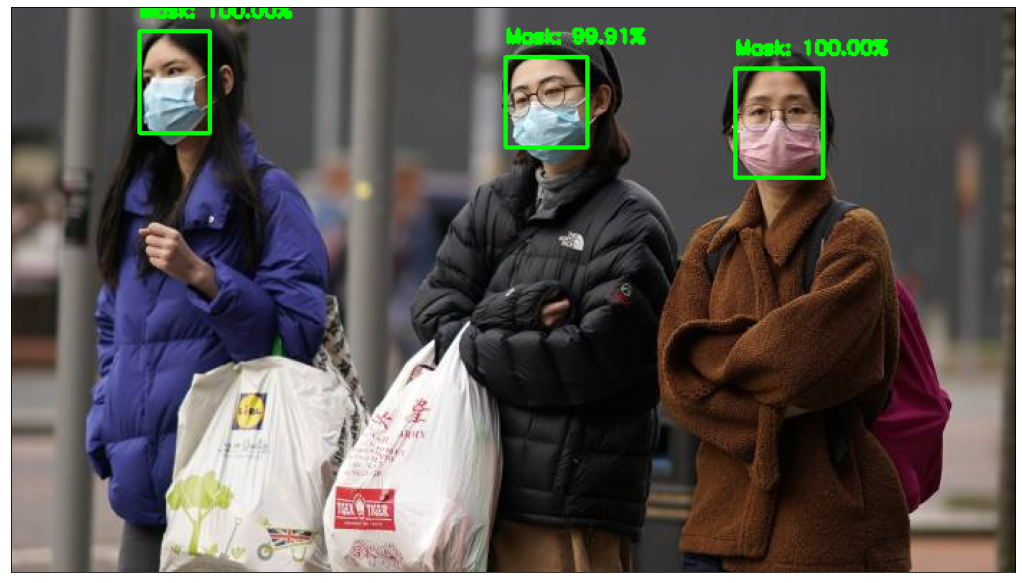

In [27]:
face_frame_detection(cv2.imread("1.png"))

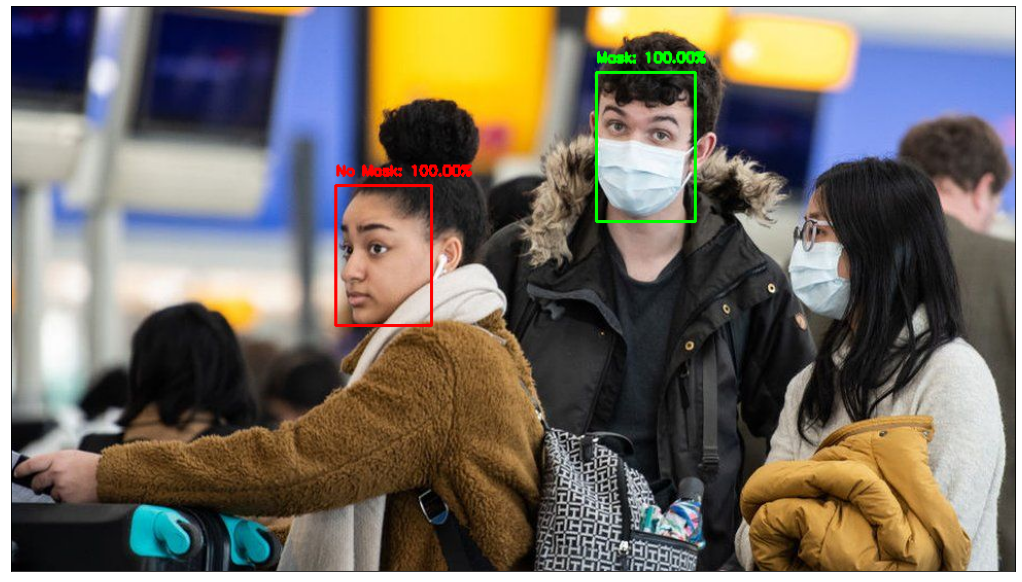

In [28]:
face_frame_detection(cv2.imread("2.png"))

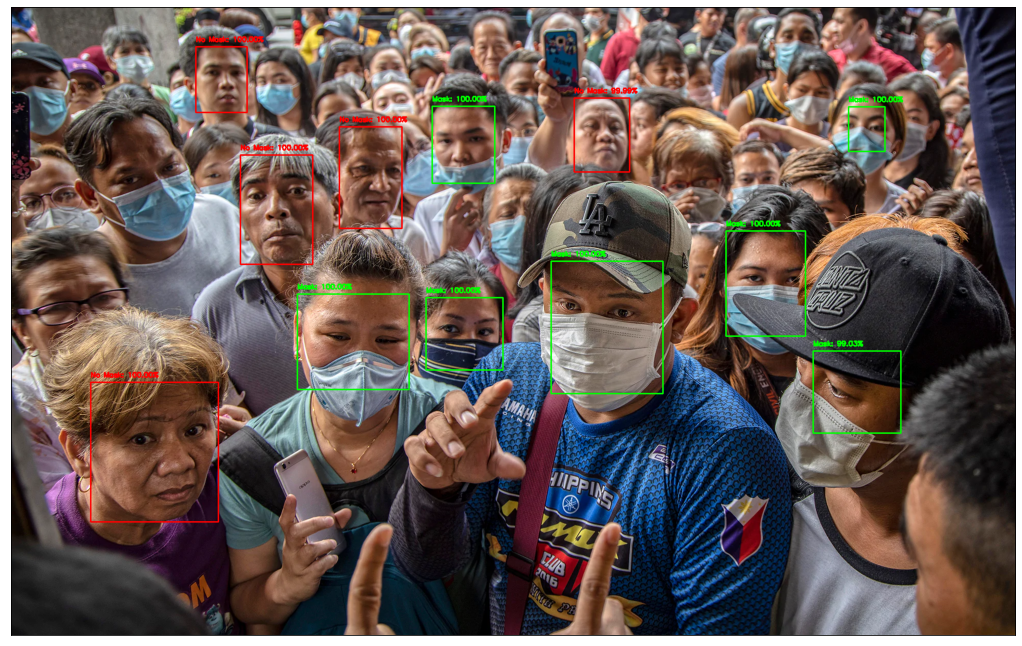

In [29]:
face_frame_detection(cv2.imread("3.png"))

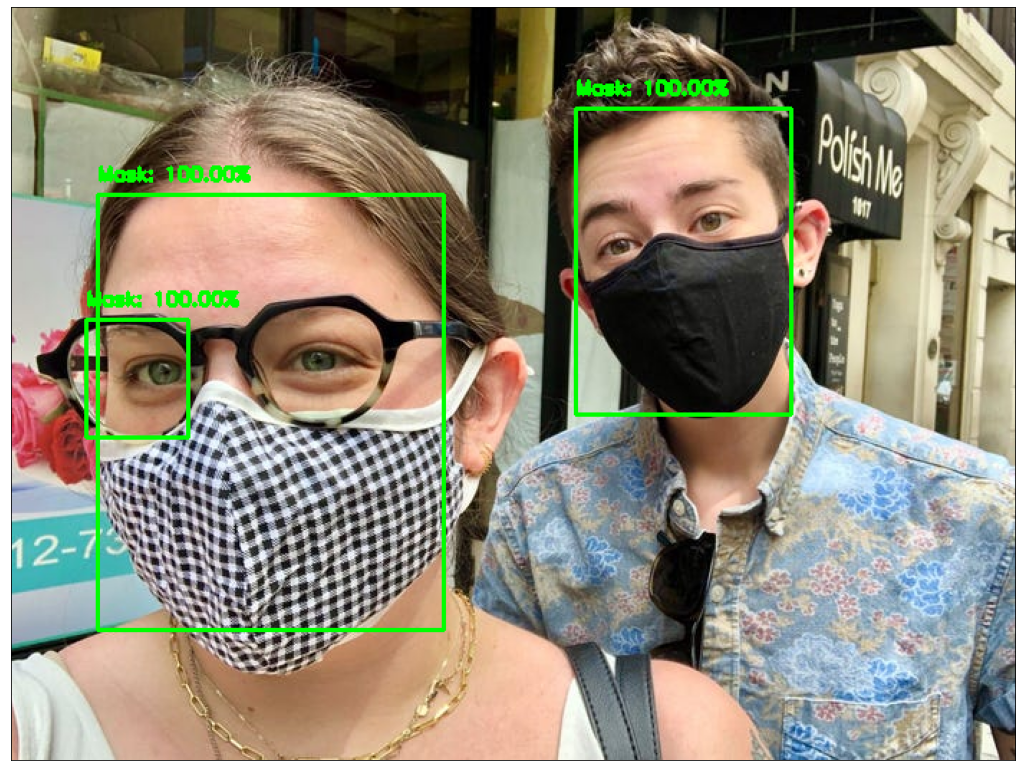

In [32]:
face_frame_detection(cv2.imread("6.png"))

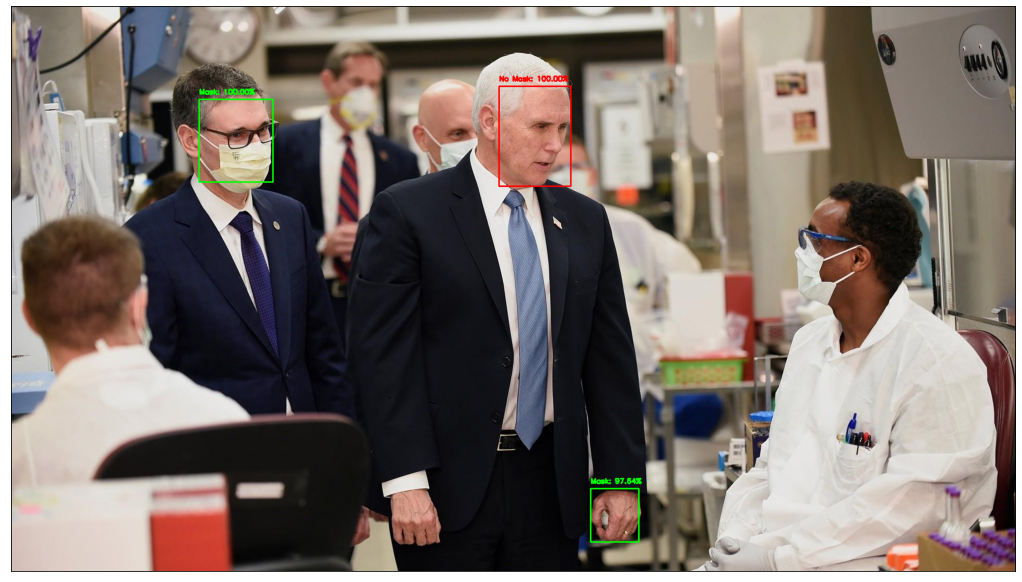

In [42]:
face_frame_detection(cv2.imread("7.png"))

## Use Webcam to Capture Photos and Detect (mask) or (no mask)

In [34]:
# This Code from Google Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [43]:
def img_capture():
    try:
      filename = take_photo()
      print('Saved to {}'.format(filename))
      
      # Show the image which was just taken.
      display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


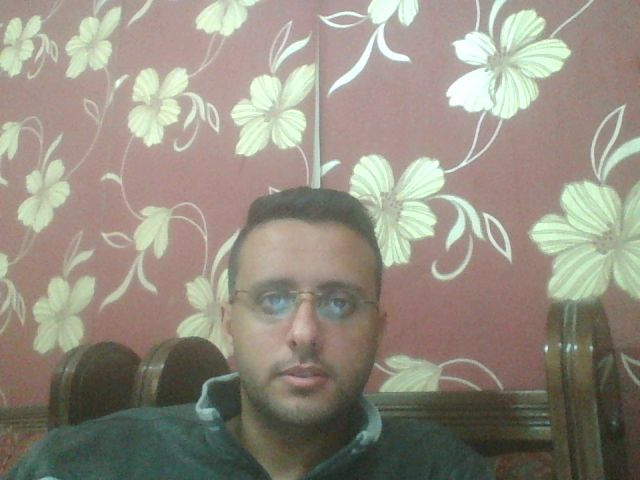

In [47]:
img_capture()

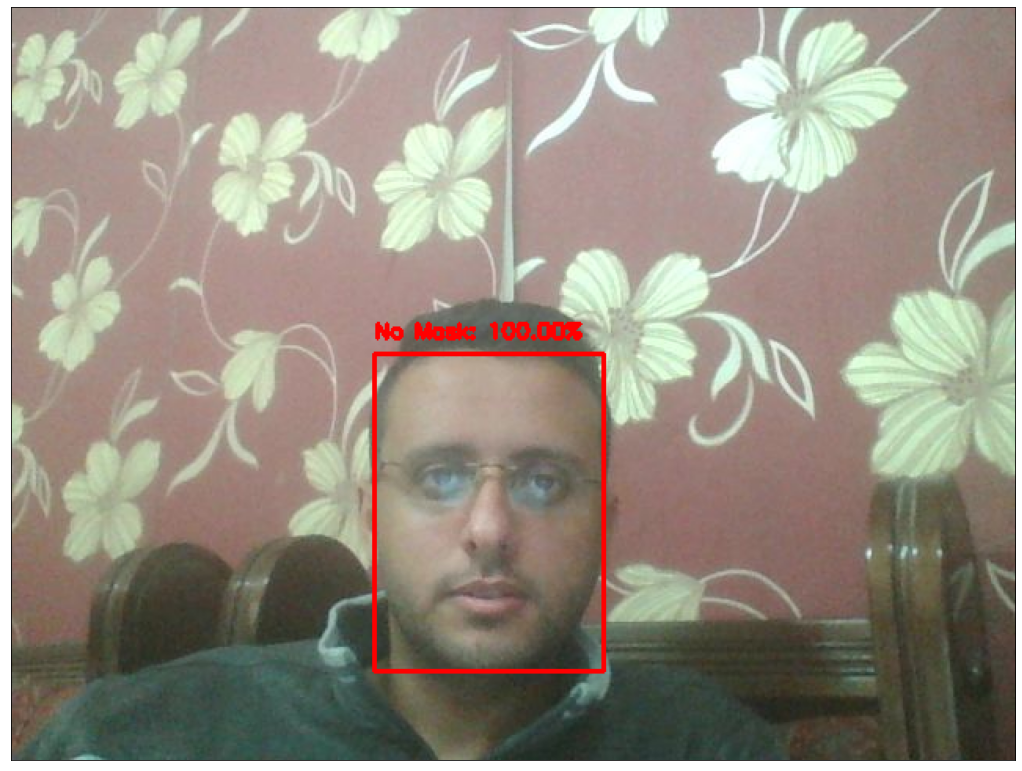

In [48]:
face_frame_detection(cv2.imread("photo.jpg"))

<IPython.core.display.Javascript object>

Saved to photo.jpg


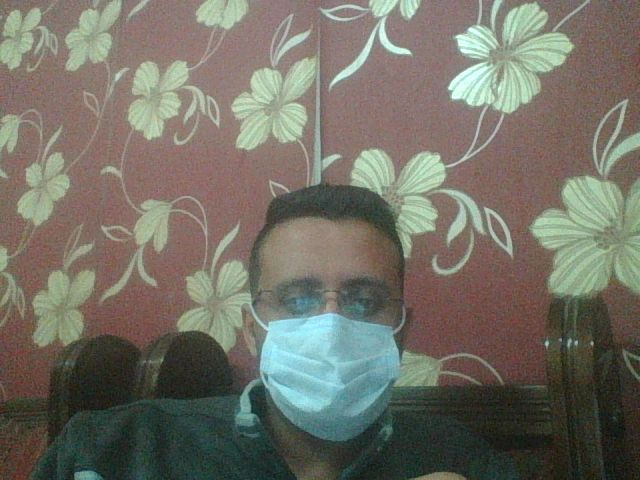

In [49]:
img_capture()

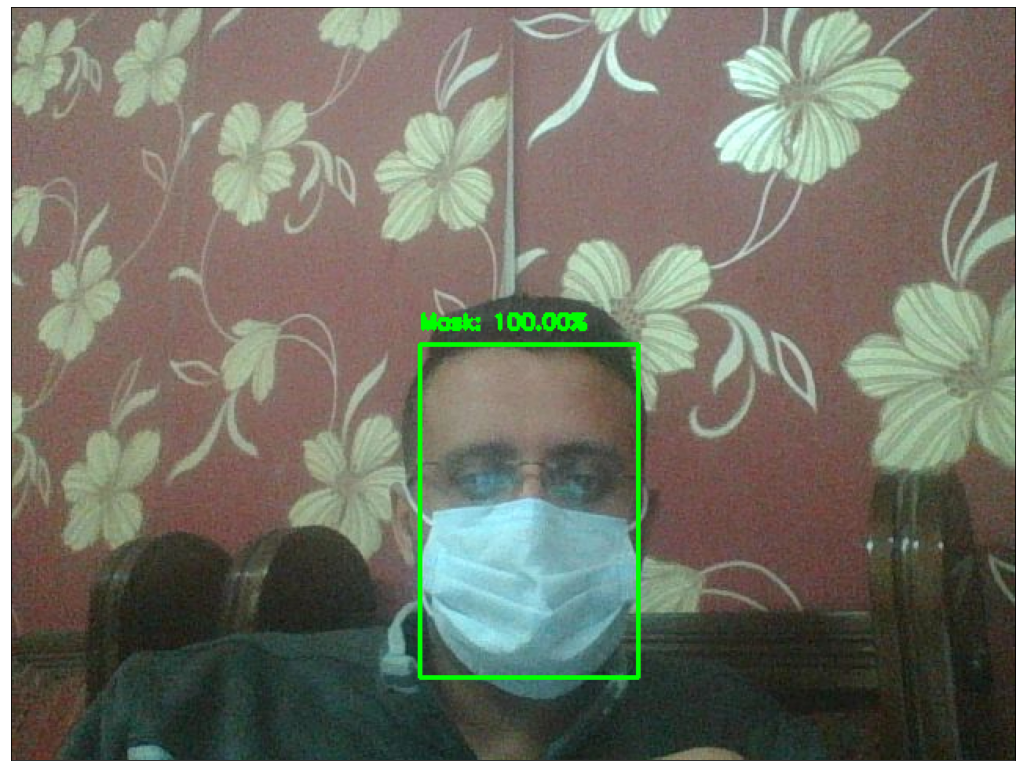

In [50]:
face_frame_detection(cv2.imread("photo.jpg"))